In [2]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import optuna

In [13]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [14]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [15]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")

xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")

# new
xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\swing_2022&3_xswing.csv")

# new
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\whiff_2022&3_xwhiff.csv")

# all updated
xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\ld_2022&3_xld.csv")

# new
xfob = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\foul_2022&3_xfoul.csv")

# new
xcs = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\cs_2022&3_xcalledstrike.csv")

In [16]:
# rename and drop columns from expected dfs

xpfx_z.rename(columns={'pfx_z': 'pfx_z_cor'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_predicted': 'pfx_z_cor_predicted'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff': 'pfx_z_cor_diff'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff_abs': 'pfx_z_cor_diff_abs'}, inplace=True)

xspin_axis.rename(columns={'spin_axis': 'spin_axis_cor'}, inplace=True)

xswing = xswing[['pitch_id_raw', 'xswing']]
xwhiff = xwhiff[['pitch_id_raw', 'xwhiff']]

xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]
xfob = xfob[['pitch_id_raw', 'xfoul']]
xcs = xcs[['pitch_id_raw', 'xcs']]

In [17]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [18]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [19]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [20]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [21]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [22]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [23]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')
df = pd.merge(df, xfob, on='pitch_id_raw', how='left')
df = pd.merge(df, xcs, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xfob, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xcs, on='pitch_id_raw', how='left')

In [25]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['xswing'] < 0, 'xswing'] = 0
df_2023.loc[df_2023['xswing'] < 0, 'xswing'] = 0

In [26]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['xswing'] * df['xwhiff']
df_2023['swing_whiff'] = df_2023['xswing'] * df_2023['xwhiff']

In [29]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor', \
            'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted', \
                'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio', 'xswing', 'xwhiff', 'swing_whiff', 'xfb', 'xgb', 'xld', 'xfoul', 'xcs']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 11,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 500, 1000]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 9]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=30)
    
    preds = model.predict_proba(X_valid)
    logloss = log_loss(y_valid, preds)
    
    return logloss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Output the best parameters
print(study.best_params)

[I 2023-11-09 18:44:36,425] A new study created in memory with name: no-name-51375fb6-d377-4b0b-8a7e-21f80be5bc17
C:\Users\adam.bloebaum\AppData\Local\Temp\ipykernel_10420\74371013.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\adam.bloebaum\AppData\Local\Temp\ipykernel_10420\74371013.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated 

KeyboardInterrupt: 

In [30]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [31]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.4292826983623362
Confusion Matrix:
[[16131     1     0    81  3325     0     0  5480   188     0    14]
 [  222     0     0    13   404     0     0   329    16     0     8]
 [   97     0     0     9   181     0     0   158     3     0    10]
 [ 2114     0     0   159  4059     0     2  2814   136     0    94]
 [ 4415     1     0   182  7330     0     1  5041   243     0   184]
 [  132     0     0     7   268     0     0   230     5     0     9]
 [  739     0     0    64  1449     1     0   957    48     0    31]
 [ 5214     0     0    47  2220     0     1 10678     0     0   168]
 [ 1032     0     0    96  2397     0     2     7   260     0   112]
 [   15     0     0     1    16     0     0    30     5     0     3]
 [  534     0     0    23   656     1     0   371    52     0   620]]


<Figure size 1000x5000 with 0 Axes>

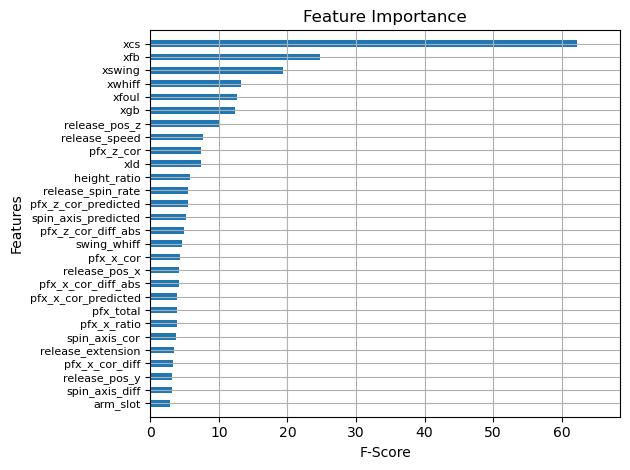

In [32]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [33]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

xcs: 62.266212463378906
xfb: 24.717998504638672
xswing: 19.292619705200195
xwhiff: 13.232781410217285
xfoul: 12.654810905456543
xgb: 12.41045093536377
release_pos_z: 10.028892517089844
release_speed: 7.65318489074707
pfx_z_cor: 7.406073093414307
xld: 7.325446128845215
height_ratio: 5.722741603851318
release_spin_rate: 5.570683002471924
pfx_z_cor_predicted: 5.487996578216553
spin_axis_predicted: 5.252028465270996
pfx_z_cor_diff_abs: 4.916929721832275
swing_whiff: 4.614099025726318
pfx_x_cor: 4.313669681549072
release_pos_x: 4.172631740570068
pfx_x_cor_diff_abs: 4.143051624298096
pfx_x_cor_predicted: 3.918424129486084
pfx_total: 3.91255784034729
pfx_x_ratio: 3.889343023300171
spin_axis_cor: 3.6968259811401367
release_extension: 3.5003957748413086
pfx_x_cor_diff: 3.306393623352051
release_pos_y: 3.1661384105682373
spin_axis_diff: 3.1363072395324707
arm_slot: 2.9466450214385986


In [34]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [35]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [36]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [37]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
           player_name pitch_type  pitch_quality
869   Wainwright, Adam         FF       0.023011
753     Shuster, Jared         FF       0.019196
59        Beeks, Jalen         FF       0.015850
921       Winder, Josh         FF       0.015097
421  Kaprielian, James         FF       0.014706
141        Cessa, Luis         FF       0.014507
805     Suárez, Andrew         FF       0.013719
621        Oller, Adam         FF       0.013678
355    Hendricks, Kyle         FF       0.013653
219       Doyle, Tommy         FF       0.012767

Bottom 10:
           player_name pitch_type  pitch_quality
145   Chapman, Aroldis         SI      -0.022924
159    Clase, Emmanuel         FC      -0.019783
241    Fairbanks, Pete         FF      -0.017980
56     Bautista, Félix         FF      -0.017823
687    Rasmussen, Drew         FF      -0.017662
735    Schmidt, Clarke         FC      -0.016398
740      Scott, Tanner         FF      -0.016170
317  Graterol, Brusdar         SI      -0.015942


In [38]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Chapman, Aroldis",SI,205
2,"Clase, Emmanuel",FC,191
3,"Fairbanks, Pete",FF,183
4,"Bautista, Félix",FF,182
5,"Rasmussen, Drew",FF,182
6,"Schmidt, Clarke",FC,176
7,"Scott, Tanner",FF,175
8,"Graterol, Brusdar",SI,174
9,"Helsley, Ryan",FF,173
10,"Kluber, Corey",FC,172


In [134]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_fb_v4.png', dpi=300)
plt.close()


In [ ]:
# save 2022 and 2023 dfs to y drive

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_stuff_plus.csv")
df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures_stuff_plus.csv")

In [286]:
# heater avg metrics function for breaking ball model

def heater_stats(df):
    grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    heater_df = grouped_df[idx]
    heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    return final_df

heaters_2022 = heater_stats(df)

heaters_2022.head(5)

,player_name,fb_pitch_type,fb_release_speed,fb_release_pos_x,fb_release_pos_z,fb_pfx_x,fb_pfx_z,fb_ax,fb_ay,fb_az,fb_vx0,fb_vy0,fb_vz0,fb_release_spin_rate,fb_release_extension,fb_spin_axis
0,"Abbott, Cory",FF,91.339394,-2.604336,5.483357,-0.958858,1.433054,-13.081828,29.542563,-14.719764,8.050058,-132.711096,-3.466317,2252.992974,6.273660,140.946136
1,"Abreu, Albert",SI,98.542120,-1.716819,5.690630,-1.225072,1.095673,-18.387419,33.002983,-15.709709,6.615544,-143.233904,-6.668397,2200.747851,6.616905,140.134670
2,"Abreu, Bryan",FF,97.265184,-1.868743,5.770135,-0.531605,1.431257,-8.659995,33.613207,-11.755046,6.546375,-141.353165,-6.171281,2318.727273,6.508704,149.615087
3,"Acevedo, Domingo",FF,93.019529,-1.872165,5.399200,-1.135859,1.113153,-15.536291,30.177170,-17.953813,7.259131,-135.221947,-3.487165,2117.807059,5.730824,127.442353
4,"Adam, Jason",FF,94.768831,-1.647597,5.844773,-0.568442,1.468604,-8.478304,31.858367,-12.589142,5.438304,-137.829760,-4.791478,2656.357143,6.700325,145.918831
